# データの読み込み

In [1]:
#tensorboardの拡張機能読み込み
%load_ext tensorboard

In [2]:
#warningはpythonの標準ライブラリ．
#FutureWarnigが邪魔なので非表示にする．動作に支障が無ければ問題ない．また最適化によって解が収束しないときに出るConvergenceWarningも邪魔なので非表示にする．
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=(FutureWarning, ConvergenceWarning))#対象のwarningsクラスはタプルで渡す必要があるらしい

In [3]:
import pprint
import sys
sys.path.append("/mnt/MachineLearning")
pprint.pprint(sys.path)

['/mnt/MachineLearning/MLTrial',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/mnt/MachineLearning']


In [4]:
#各種モジュールのimport
%matplotlib inline
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import statistics

from modules import show_mod
from modules.log_controler import ControlLog

from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras import optimizers
from keras.layers import BatchNormalization
from keras.layers import ReLU, LeakyReLU, PReLU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, TensorBoard

import optuna

In [7]:
#読み込むデータのパスの設定
current_dir_path = os.getcwd()
data_path = "/mnt/MachineLearning/data"
input_list = glob.glob(data_path+"/*"+"/inputdata.csv")
output_list = glob.glob(data_path+"/CountResults"+"/sitting"+"/count_from2sec_patientAverage.csv")
num_input = len(input_list)
print("data path:", data_path)

data path: /mnt/MachineLearning/data


In [8]:
#input(空調条件等)の読み込み
df_input = None

for input_fname in input_list:
    df_read = pd.read_csv(input_fname, index_col="case_name")
    if df_input is None:
        df_input = df_read
    else:
        df_input = df_input.append(df_read)

df_input

,aircon,ventilation,exhaust,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,3_x,3_y,3_z,3_angle,4_x,4_y,4_z,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y,aircon_position_x,aircon_position_y
case_name,,,,,,,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_246_aout,660,246,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_82_bout,660,82,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_82_aout,660,82,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_164_bout,660,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,b,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,NaN,NaN
office6_660_0,660,0,off,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,NaN,NaN
office6_360_246_aout,360,246,a,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,NaN,NaN


In [9]:
#入力データの選択(オフィスサイズとエアコン位置が被っていると思うので削除)
delete_cols = ["aircon_position_x", "aircon_position_y"]
df_input.drop(df_input[delete_cols], axis=1, inplace=True)
df_input

,aircon,ventilation,exhaust,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,3_x,3_y,3_z,3_angle,4_x,4_y,4_z,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y
case_name,,,,,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5
office22_660_246_aout,660,246,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5
office22_660_82_bout,660,82,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5
office22_660_82_aout,660,82,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5
office22_660_164_bout,660,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,b,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5
office6_660_0,660,0,off,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5
office6_360_246_aout,360,246,a,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5


In [10]:
#排気口位置a,b,offをダミー変数化
df_input = pd.get_dummies(df_input, columns=['exhaust'])
df_input

,aircon,ventilation,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,3_x,3_y,3_z,3_angle,4_x,4_y,4_z,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
case_name,,,,,,,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,0,1,0
office22_660_246_aout,660,246,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,1,0,0
office22_660_82_bout,660,82,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,0,1,0
office22_660_82_aout,660,82,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,1,0,0
office22_660_164_bout,660,164,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,0,1,0
office6_660_0,660,0,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,0,0,1
office6_360_246_aout,360,246,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,1,0,0


In [46]:
df_output = pd.read_csv(output_list[0], index_col="casename")
df_output

,num_drop,volume[ml],RoI
casename,,,
office2_0_0,6739.4,0.000067,204.224242
office2_0_164_aout,7865.4,0.000063,238.345455
office2_0_164_bout,6049.8,0.000062,183.327273
office2_0_246_aout,7934.4,0.000050,240.436364
office2_0_246_bout,7662.0,0.000082,232.181818
...,...,...,...
office3_960_164_bout,5117.4,0.000075,155.072727
office3_960_246_aout,4428.0,0.000073,134.181818
office3_960_246_bout,3890.0,0.000066,117.878788


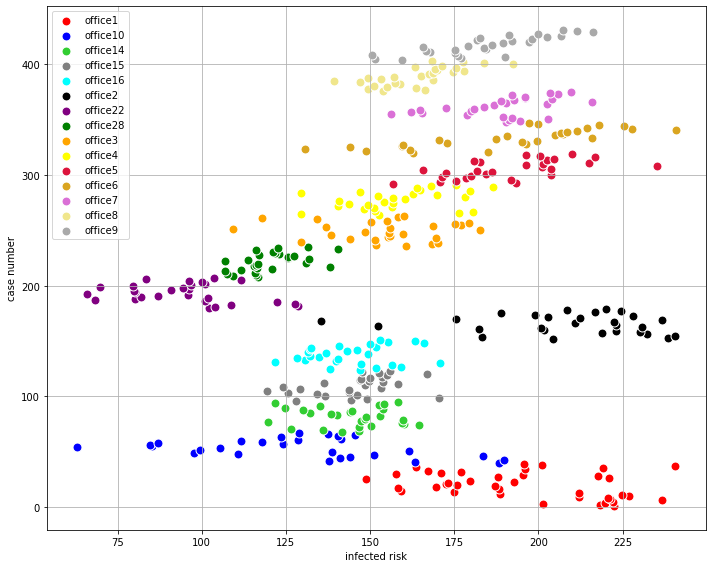

In [12]:
#df_outputの値の幅を見てみる
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_output.index.str.extract("(office+[0-9]{1,2})").to_numpy()

plt.figure(figsize=[10, 8])

#カラーマップ等の準備
markers = ("s", "x", "o", "^", "v", "<", ">", "1", "2", "3", "4", "8")
colors = ("red", "blue", "limegreen", "gray", "cyan", "black", "purple", "green",
          "orange", "yellow", "crimson", "goldenrod", "orchid", "khaki", "darkgray")
start_index = 0

for idx, target_office_name in enumerate(np.unique(office_list)):
    target_office_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == target_office_name)]
    plt.scatter(df_output.iloc[target_office_index ,2], range(1+start_index, len(target_office_index)+1+start_index), 
                s=80, c=colors[idx], marker=markers[2], edgecolor="white", label=target_office_name)
    start_index += len(target_office_index)
    

plt.ylabel("case number")
plt.xlabel("infected risk")
plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

# データの前処理

In [96]:
#単に等分してみる
#今回は分類問題なので，感染リスクの値をラベリングして離散化する
RoI_max = df_output.max(axis=0)["RoI"]
RoI_min = df_output.min(axis=0)["RoI"]

#分類のラベルの数を指定
classification_level = 5

level_defference = (RoI_max - RoI_min) / 5

threshold = []#ラベルをつけるための領域を分ける閾値
for i in range(classification_level+1):
    if i == 0:
        threshold.append(RoI_min)
    elif i == classification_level:
        threshold.append(RoI_max)
    else:
        threshold.append(threshold[i-1] + level_defference)
    
print("threshold")
pprint.pprint(threshold)

label = []
#感染リスクの行列を参照するためのループ
for RoI in df_output["RoI"]:
    
    #どの領域に入っているかを探るループ
    for i in range(classification_level):
        #カウント漏れや二重カウントを防ぐため，大小比較を調整
        if i == max(range(classification_level)):
            if RoI >= threshold[max(range(classification_level))]:
                label.append(i)
        elif i == min(range(classification_level)):
            if RoI < threshold[min(range(classification_level)) + 1]:
                label.append(i)
        else:
            if RoI >= threshold[i] and RoI < threshold[i + 1]:
                label.append(i)
                
#データフレーム化
df_label = pd.DataFrame(label, index=df_output.index, columns=["RoI_level"])
#各ラベルの個数カウント
for i in range(classification_level):
    print(f"num RoI_level{i}: {(df_label['RoI_level'] == i).sum()}")
    
#結合
df_output_add = pd.merge(df_output, df_label, left_index=True, right_index=True)
print(f"num null in df:{df_output_add.isnull().values.sum()}\n")#結合が上手く行っていないかどうか確認
df_output_add.head()


threshold
[62.96190476190476,
 98.52225108225107,
 134.0825974025974,
 169.64294372294373,
 205.20329004329005,
 240.76363636363635]
num RoI_level0: 21
num RoI_level1: 71
num RoI_level2: 163
num RoI_level3: 123
num RoI_level4: 53
num null in df:0



,num_drop,volume[ml],RoI,RoI_level
casename,,,,
office2_0_0,6739.4,0.000067,204.224242,3
office2_0_164_aout,7865.4,0.000063,238.345455,4
office2_0_164_bout,6049.8,0.000062,183.327273,3
office2_0_246_aout,7934.4,0.000050,240.436364,4
office2_0_246_bout,7662.0,0.000082,232.181818,4


メモ:\
ラベルを色分けに使って，様々な軸でプロットしたら何かわかりそうな気もする\
値の幅をただ分割レベルに応じて等分したが，これでは外れ値の影響を大きく受ける可能性がある．\
そのため四分位数などを使ったほうが良いかも．

In [108]:
#四分位数バージョン
classification_level = 4

data_describe = df_output["RoI"].describe()
print(data_describe)

threshold = data_describe[3:8]
print("\nthreshold")
pprint.pprint(threshold)

label = []
#感染リスクの行列を参照するためのループ
for RoI in df_output["RoI"]:
    
    #どの領域に入っているかを探るループ
    for i in range(classification_level):
        #カウント漏れや二重カウントを防ぐため，大小比較を調整
        if i == max(range(classification_level)):
            if RoI >= threshold[max(range(classification_level))]:
                label.append(i)
        elif i == min(range(classification_level)):
            if RoI < threshold[min(range(classification_level)) + 1]:
                label.append(i)
        else:
            if RoI >= threshold[i] and RoI < threshold[i + 1]:
                label.append(i)
                
#データフレーム化
df_label = pd.DataFrame(label, index=df_output.index, columns=["RoI_level"])
#各ラベルの個数カウント
for i in range(classification_level):
    print(f"num RoI_level{i}: {(df_label['RoI_level'] == i).sum()}")

#結合
df_output_add = pd.merge(df_output, df_label, left_index=True, right_index=True)
print(f"num null in df:{df_output_add.isnull().values.sum()}")#結合が上手く行っていないかどうか確認
df_output_add

count    431.000000
mean     161.902247
std       36.376848
min       62.961905
25%      138.530952
50%      159.866667
75%      188.787879
max      240.763636
Name: RoI, dtype: float64

threshold
min     62.961905
25%    138.530952
50%    159.866667
75%    188.787879
max    240.763636
Name: RoI, dtype: float64
num RoI_level0: 108
num RoI_level1: 107
num RoI_level2: 108
num RoI_level3: 108
num null in df:0


,num_drop,volume[ml],RoI,RoI_level
casename,,,,
office2_0_0,6739.4,0.000067,204.224242,3
office2_0_164_aout,7865.4,0.000063,238.345455,3
office2_0_164_bout,6049.8,0.000062,183.327273,2
office2_0_246_aout,7934.4,0.000050,240.436364,3
office2_0_246_bout,7662.0,0.000082,232.181818,3
...,...,...,...,...
office3_960_164_bout,5117.4,0.000075,155.072727,1
office3_960_246_aout,4428.0,0.000073,134.181818,0
office3_960_246_bout,3890.0,0.000066,117.878788,0


In [111]:
df_total = pd.merge(df_input, df_output_add, left_index=True, right_index=True)
print(f"num null in df:{df_total.isnull().values.sum()}")#結合が上手く行っていないかどうか確認
df_total

num null in df:0


,aircon,ventilation,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,3_x,3_y,3_z,3_angle,4_x,4_y,4_z,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off,num_drop,volume[ml],RoI,RoI_level
office22_360_164_bout,360,164,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,0,1,0,5629.6,0.000047,101.893213,0
office22_660_246_aout,660,246,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,1,0,0,5321.0,0.000041,96.307692,0
office22_660_82_bout,660,82,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,0,1,0,4394.8,0.000048,79.543891,0
office22_660_82_aout,660,82,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,1,0,0,3848.2,0.000035,69.650679,0
office22_660_164_bout,660,164,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,2.730,2.315,1.255,90.0,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,0,1,0,5014.6,0.000059,90.761991,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,0,1,0,6504.6,0.000077,197.109091,3
office6_660_0,660,0,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,0,0,1,7121.0,0.000096,215.787879,3
office6_360_246_aout,360,246,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,1,0,0,6435.6,0.000058,195.018182,3
office6_960_0,960,0,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,4.734,3.710,1.255,180.0,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,0,0,1,7945.2,0.000093,240.763636,3


In [112]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, office22_360_164_bout to office6_960_246_bout
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   aircon         431 non-null    int64  
 1   ventilation    431 non-null    int64  
 2   1_x            431 non-null    float64
 3   1_y            431 non-null    float64
 4   1_z            431 non-null    float64
 5   1_angle        431 non-null    float64
 6   2_x            431 non-null    float64
 7   2_y            431 non-null    float64
 8   2_z            431 non-null    float64
 9   2_angle        431 non-null    float64
 10  3_x            431 non-null    float64
 11  3_y            431 non-null    float64
 12  3_z            431 non-null    float64
 13  3_angle        431 non-null    float64
 14  4_x            431 non-null    float64
 15  4_y            431 non-null    float64
 16  4_z            431 non-null    float64
 17  4_angle        431 non

## 統計分析

In [113]:
#基礎統計量について確認
df_total.describe()

,aircon,ventilation,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,3_x,3_y,3_z,3_angle,4_x,4_y,4_z,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off,num_drop,volume[ml],RoI,RoI_level
count,431.000000,431.000000,431.000000,431.000000,4.310000e+02,431.000000,431.000000,431.000000,4.310000e+02,431.000000,431.000000,431.000000,4.310000e+02,431.000000,431.000000,431.000000,4.310000e+02,431.000000,431.000000,431.000000,4.310000e+02,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000
mean,499.071926,139.837587,3.337392,2.765791,1.255000e+00,86.450116,3.618077,3.061318,1.255000e+00,147.215777,3.191928,2.818218,1.255000e+00,158.909513,3.146573,2.018503,1.255000e+00,119.234339,3.485668,1.641705,1.255000e+00,119.234339,7.364269,5.370070,0.431555,0.431555,0.136891,6130.170302,0.000066,161.902247,1.501160
std,360.876287,83.985694,1.939957,1.115080,4.446053e-16,83.972153,1.242520,0.838024,4.446053e-16,103.603211,1.471667,1.174327,4.446053e-16,106.607163,1.304819,1.197461,4.446053e-16,90.054858,1.326876,1.040555,4.446053e-16,90.054858,1.370630,0.754404,0.495869,0.495869,0.344132,921.844114,0.000017,36.376848,1.120371
min,0.000000,0.000000,0.560000,0.810000,1.255000e+00,0.000000,1.266000,0.940000,1.255000e+00,0.000000,0.940000,0.984000,1.255000e+00,0.000000,0.985000,0.940000,1.255000e+00,0.000000,0.985000,0.540000,1.255000e+00,0.000000,6.000000,4.000000,0.000000,0.000000,0.000000,2644.400000,0.000025,62.961905,0.000000
25%,0.000000,82.000000,1.266000,2.180000,1.255000e+00,0.000000,2.930000,2.540000,1.255000e+00,90.000000,1.835000,1.266000,1.255000e+00,90.000000,2.390000,1.141000,1.255000e+00,90.000000,2.760000,0.984000,1.255000e+00,90.000000,6.000000,5.000000,0.000000,0.000000,0.000000,5540.500000,0.000055,138.530952,0.500000
50%,660.000000,164.000000,3.570000,3.016000,1.255000e+00,90.000000,3.285000,3.059000,1.255000e+00,90.000000,3.016000,3.059000,1.255000e+00,180.000000,3.016000,1.566000,1.255000e+00,90.000000,2.984000,1.266000,1.255000e+00,90.000000,7.000000,5.500000,0.000000,0.000000,0.000000,6169.400000,0.000065,159.866667,2.000000
75%,960.000000,246.000000,4.760000,3.820000,1.255000e+00,180.000000,4.760000,3.575000,1.255000e+00,270.000000,4.734000,3.840000,1.255000e+00,270.000000,4.180000,2.315000,1.255000e+00,180.000000,4.766000,2.040000,1.255000e+00,180.000000,9.000000,6.000000,1.000000,1.000000,0.000000,6791.400000,0.000076,188.787879,2.500000
max,960.000000,246.000000,7.735000,4.515000,1.255000e+00,270.000000,6.260000,4.515000,1.255000e+00,270.000000,5.016000,4.690000,1.255000e+00,270.000000,5.860000,4.760000,1.255000e+00,270.000000,5.630000,4.760000,1.255000e+00,270.000000,9.500000,6.500000,1.000000,1.000000,1.000000,8008.600000,0.000130,240.763636,3.000000


In [114]:
#口のz座標は全て同じであることがわかり特徴量として機能しないので削除
delete_cols = ["1_z","2_z","3_z","4_z","5_z"]
df_total.drop(df_total[delete_cols], axis=1, inplace=True)
df_total

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,3_angle,4_x,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off,num_drop,volume[ml],RoI,RoI_level
office22_360_164_bout,360,164,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,90.0,4.180,2.315,90.0,5.630,2.315,90.0,8.5,6.5,0,1,0,5629.6,0.000047,101.893213,0
office22_660_246_aout,660,246,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,90.0,4.180,2.315,90.0,5.630,2.315,90.0,8.5,6.5,1,0,0,5321.0,0.000041,96.307692,0
office22_660_82_bout,660,82,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,90.0,4.180,2.315,90.0,5.630,2.315,90.0,8.5,6.5,0,1,0,4394.8,0.000048,79.543891,0
office22_660_82_aout,660,82,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,90.0,4.180,2.315,90.0,5.630,2.315,90.0,8.5,6.5,1,0,0,3848.2,0.000035,69.650679,0
office22_660_164_bout,660,164,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,90.0,4.180,2.315,90.0,5.630,2.315,90.0,8.5,6.5,0,1,0,5014.6,0.000059,90.761991,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,180.0,2.984,2.260,180.0,2.984,0.810,180.0,6.0,5.5,0,1,0,6504.6,0.000077,197.109091,3
office6_660_0,660,0,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,180.0,2.984,2.260,180.0,2.984,0.810,180.0,6.0,5.5,0,0,1,7121.0,0.000096,215.787879,3
office6_360_246_aout,360,246,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,180.0,2.984,2.260,180.0,2.984,0.810,180.0,6.0,5.5,1,0,0,6435.6,0.000058,195.018182,3
office6_960_0,960,0,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,180.0,2.984,2.260,180.0,2.984,0.810,180.0,6.0,5.5,0,0,1,7945.2,0.000093,240.763636,3


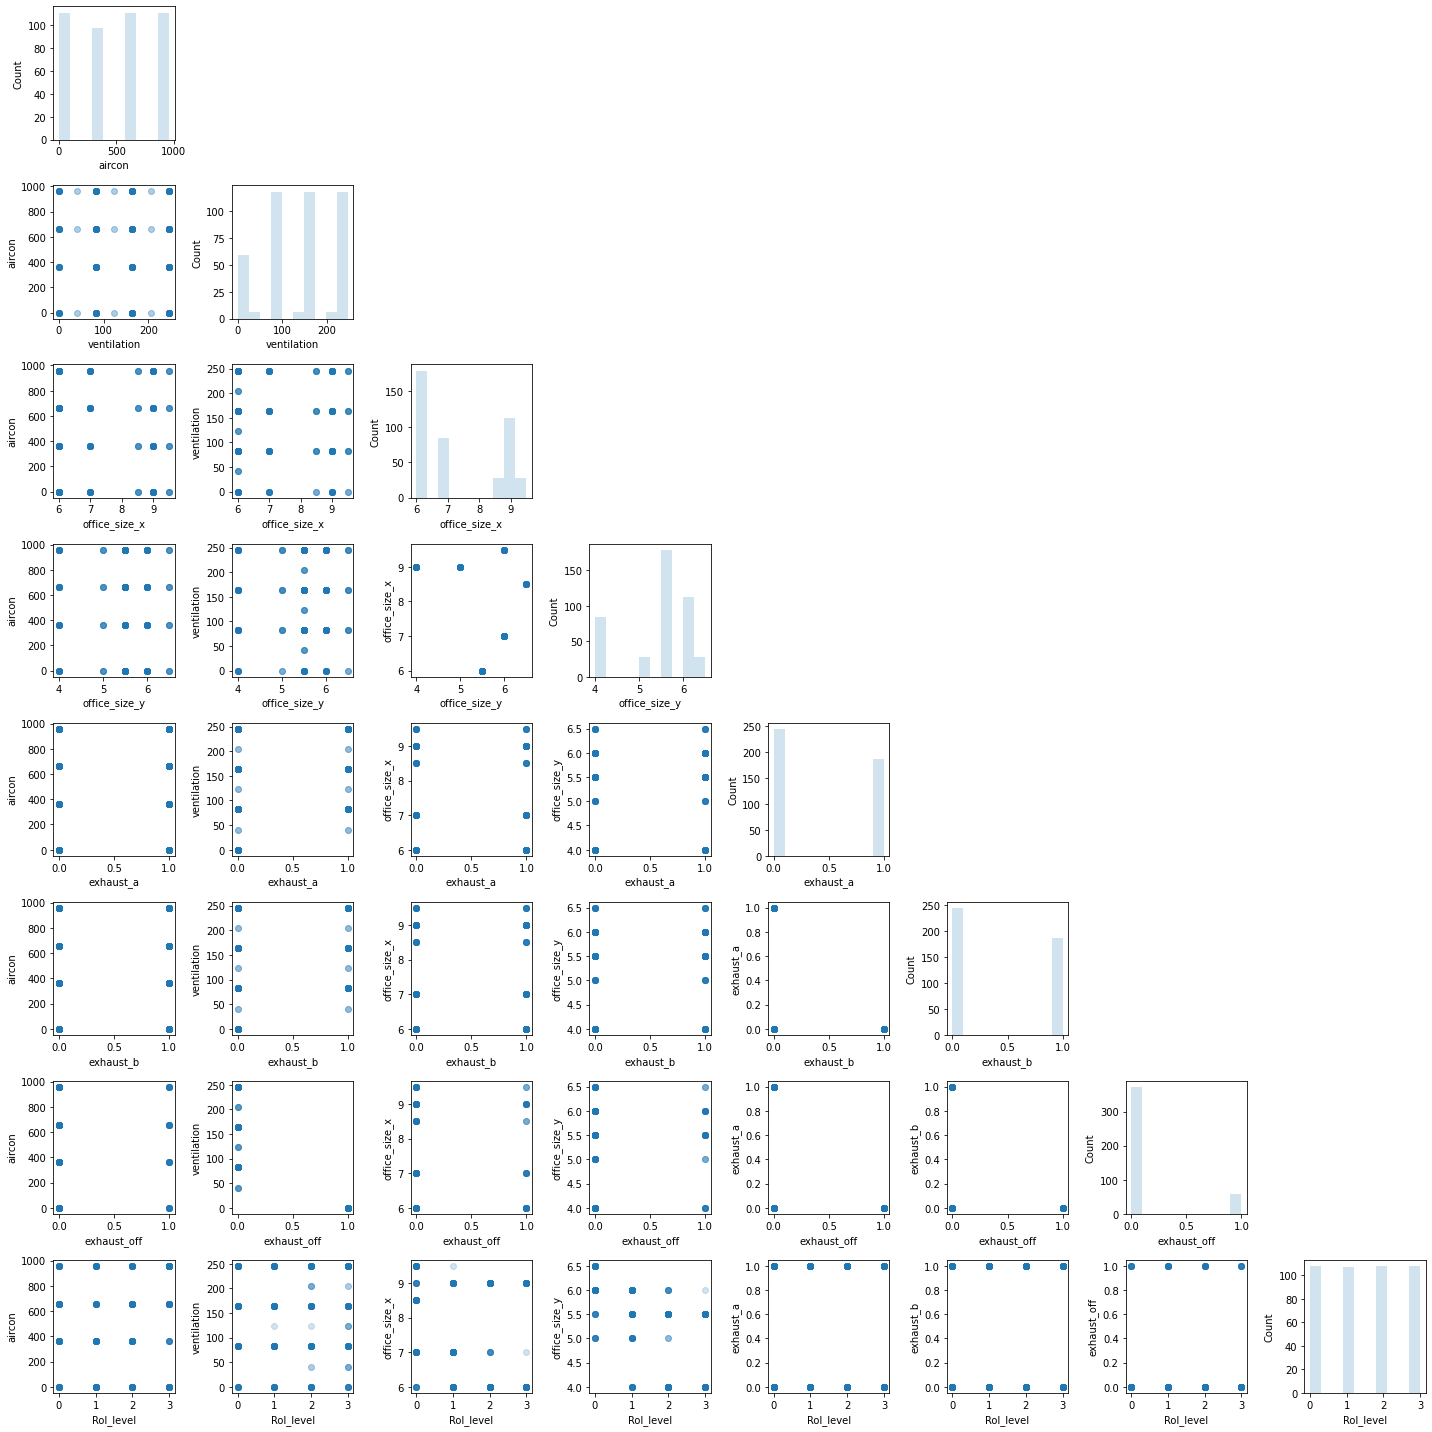

In [117]:
plot_cols = ["aircon", "ventilation", "office_size_x", "office_size_y", "exhaust_a", "exhaust_b", "exhaust_off", "RoI_level"]
# plot_cols = ['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y',"RoI"]
# plot_cols = ['1_angle','2_angle','3_angle','4_angle','5_angle',"RoI"]
scatterplotmatrix(df_total[plot_cols].values, figsize=(20, 20), names=plot_cols, alpha=0.2)
plt.tight_layout()
plt.show()

In [118]:
#説明変数と目的変数の定義
explanatory_variable =['aircon', 'ventilation', '1_x', '1_y', '1_angle', '2_x', '2_y',
                       '2_angle', '3_x', '3_y', '3_angle', '4_x', '4_y', '4_angle', '5_x', '5_y', '5_angle',
                       'office_size_x','office_size_y', 'exhaust_a', 'exhaust_b', 'exhaust_off']
objective_variable = ["RoI_level"]

df_explanatory_variable = df_total[explanatory_variable]
df_objective_variable = df_total[objective_variable]

In [119]:
#説明変数の標準化(only explanatory variable)
#目的変数は標準化する意味がないため，するべきではない．
stdscaler = preprocessing.StandardScaler()
stdscaler.fit(df_explanatory_variable)
np_explanatory_variable_std = stdscaler.transform(df_explanatory_variable)
df_explanatory_variable_std = pd.DataFrame(np_explanatory_variable_std, index=df_explanatory_variable.index, columns=df_explanatory_variable.columns)
df_explanatory_variable_std

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,3_angle,4_x,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
office22_360_164_bout,-0.385821,0.288031,0.120043,1.319112,2.188382,1.129601,1.402163,1.186516,-0.314246,-0.429014,-0.647138,0.792928,0.247892,-0.325005,1.617954,0.647805,-0.325005,0.829582,1.499520,-0.871311,1.147695,-0.398249
office22_660_246_aout,0.446455,1.265523,0.120043,1.319112,2.188382,1.129601,1.402163,1.186516,-0.314246,-0.429014,-0.647138,0.792928,0.247892,-0.325005,1.617954,0.647805,-0.325005,0.829582,1.499520,1.147695,-0.871311,-0.398249
office22_660_82_bout,0.446455,-0.689460,0.120043,1.319112,2.188382,1.129601,1.402163,1.186516,-0.314246,-0.429014,-0.647138,0.792928,0.247892,-0.325005,1.617954,0.647805,-0.325005,0.829582,1.499520,-0.871311,1.147695,-0.398249
office22_660_82_aout,0.446455,-0.689460,0.120043,1.319112,2.188382,1.129601,1.402163,1.186516,-0.314246,-0.429014,-0.647138,0.792928,0.247892,-0.325005,1.617954,0.647805,-0.325005,0.829582,1.499520,1.147695,-0.871311,-0.398249
office22_660_164_bout,0.446455,0.288031,0.120043,1.319112,2.188382,1.129601,1.402163,1.186516,-0.314246,-0.429014,-0.647138,0.792928,0.247892,-0.325005,1.617954,0.647805,-0.325005,0.829582,1.499520,-0.871311,1.147695,-0.398249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,1.278731,-0.689460,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,0.198064,-0.124739,0.201908,0.675547,-0.378522,-0.800219,0.675547,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office6_660_0,0.446455,-1.666952,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,0.198064,-0.124739,0.201908,0.675547,-0.378522,-0.800219,0.675547,-0.996516,0.172429,-0.871311,-0.871311,2.510993
office6_360_246_aout,-0.385821,1.265523,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,0.198064,-0.124739,0.201908,0.675547,-0.378522,-0.800219,0.675547,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office6_960_0,1.278731,-1.666952,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,0.198064,-0.124739,0.201908,0.675547,-0.378522,-0.800219,0.675547,-0.996516,0.172429,-0.871311,-0.871311,2.510993


In [136]:
#特定のofficeだけテストデータにする
target_office_name = ["office10"]
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_total.index.str.extract("(office+[0-9]{1,2})").to_numpy()
print(f"office list in data:\n{np.unique(office_list)}")
#リスト内包表記
test_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == target_office_name)]
#test_data_index以外をtrain_data_indexとする
train_data_bool = np.ones(office_list.shape[0], dtype = bool)
train_data_bool[test_data_index] = False
train_data_index = np.arange(office_list.shape[0])[train_data_bool]

office list in data:
['office1' 'office10' 'office14' 'office15' 'office16' 'office2'
 'office22' 'office28' 'office3' 'office4' 'office5' 'office6' 'office7'
 'office8' 'office9']


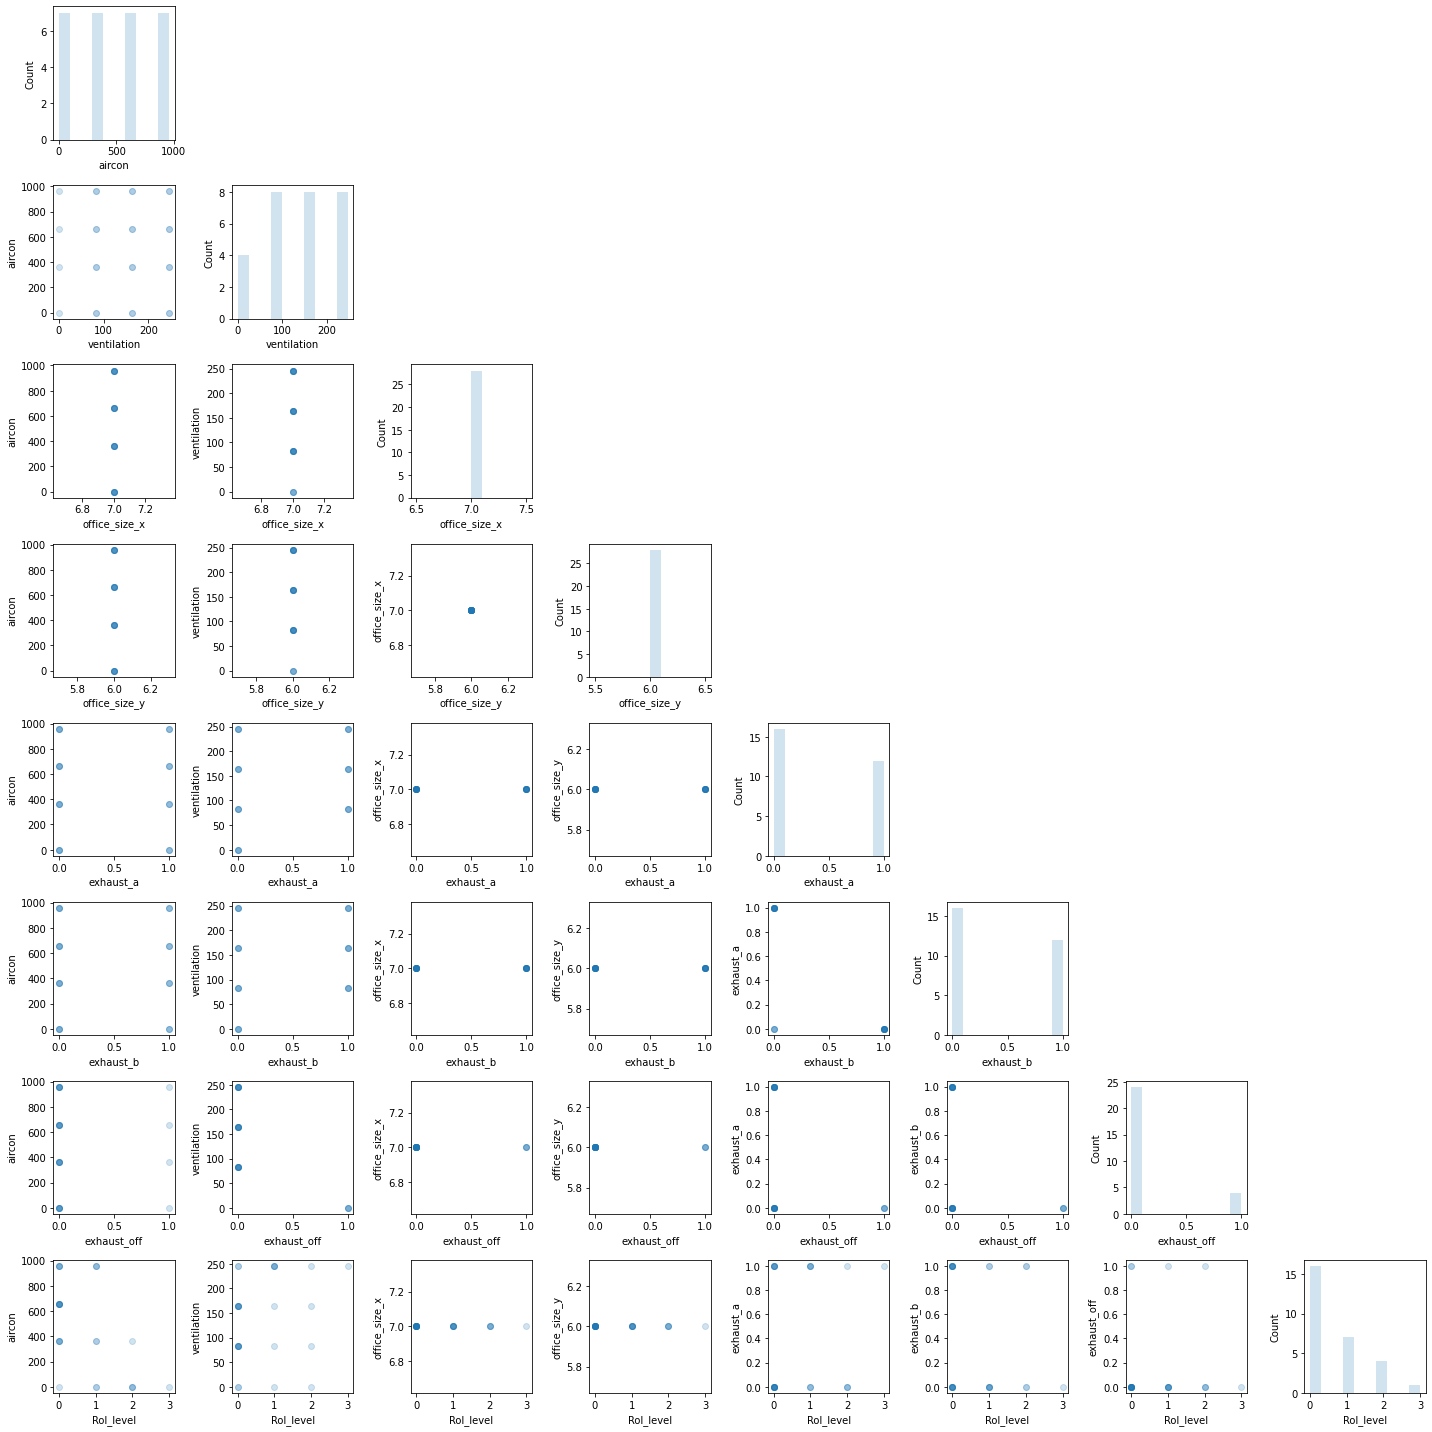

In [137]:
#各オフィスで分けて統計解析してみる(同じ形状のオフィスだけで関係を見たりしたいときに使う)
plot_cols = ["aircon", "ventilation", "office_size_x", "office_size_y", "exhaust_a", "exhaust_b", "exhaust_off", "RoI_level"]
# plot_cols = ['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y',"RoI"]
# plot_cols = ['1_angle','2_angle','3_angle','4_angle','5_angle',"RoI"]
df_target_office = df_total.iloc[test_data_index]
scatterplotmatrix(df_target_office[plot_cols].values, figsize=(20, 20), names=plot_cols, alpha=0.2)
plt.tight_layout()
plt.show()

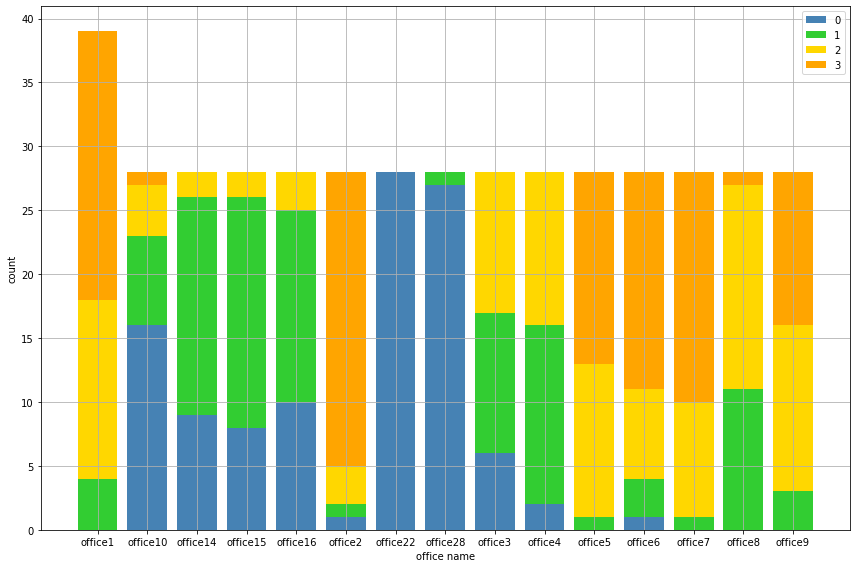

In [213]:
#オフィスごとのRoI_levelをカウントしてみる
unique_office = np.unique(office_list)
num_RoI_level = np.zeros((len(unique_office), classification_level))#ラベルのカウント数を保存するリスト

#各オフィスにアクセスするループ
count = 0#ループの回数をカウントする
for selected_office in unique_office:
    #リスト内包表記で選択したオフィスと同名のオフィスのindexを取得
    selected_office_index = [i for i in range(office_list.shape[0]) if all(office_list[i] == selected_office)]
    df_selected_office = df_total.iloc[selected_office_index]
    #各ラベルの個数カウント
    for i in range(classification_level):
        num_RoI_level[count, i] = (df_selected_office['RoI_level'] == i).sum()
        
    count += 1
    

#グラフの描画
colors = ("steelblue", "limegreen", "gold","orange","crimson")
plt.figure(figsize=[12, 8]) 
virtical = num_RoI_level#縦軸の値
horizontal = np.arange(unique_office.shape[0])#横軸の値
for level in range(classification_level):
    plt.bar(x=horizontal, height=virtical[:, level], tick_label=unique_office, bottom=virtical[:, :level].sum(axis=1), color=colors[level])

plt.ylabel("count")
plt.xlabel("office name")
plt.legend(np.arange(classification_level), loc="best")
plt.tight_layout()
plt.grid()
plt.show()